Set up Colab requirements if in Colab, or autoreload if in jupyter

In [1]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2
    

In [148]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff



In [156]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()

In [157]:
trip_dfs[0][0].bearing_road.median()

-13.99349983

As direction calculation can get quite noisy at low speeds, we remove driving under 30 km/h. 

# Calculate offset and append to all dataframes
The output of the cell is already stored and loaded

In [7]:
# from calculate_offset import batch_append_offset
# trip_dfs_out = batch_append_offset(trip_dfs, trip_names, road_dfs, save_path=None)

# Create labeled time windows

Select trip and device

<img src="figures/sections.jpg" width=180 height=250 />

In [144]:
# select trip and device
trip_nr = 2
dev_nr = 4
# sections = ['A', 'M']
sections = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
road_type = 'all'
trip_df, lca_df, trip_name = selector(trip_dfs, lca_dfs, trip_names, trip_nr, dev_nr, sections, road_type)
print(trip_name)

03 GPS S9.csv


Calculate signals

In [154]:
EWM_SPAN=3
MEDFILT_SIZE = 4

trip_df['lat_vel'] = derivative(trip_df.t, trip_df['offset'])

from config import EWM_SPAN
trip_df['offset_ewmfilt'] = trip_df.offset.ewm(span=EWM_SPAN).mean()
trip_df['lat_vel_ewmfilt'] = derivative(trip_df.t, trip_df['offset_ewmfilt'])

trip_df['bearing_diff'] = (trip_df.bearing_gps- trip_df.bearing_road) * np.pi/180
trip_df['proj_lat_dist'] = np.sin(trip_df.bearing_diff)*trip_df.distance_gps

trip_df['bearing_diff_ewmfilt'] = trip_df.bearing_diff.ewm(span=EWM_SPAN).mean()
trip_df['proj_lat_dist_ewmfilt'] = np.sin(trip_df.bearing_diff_ewmfilt) * trip_df.distance_gps
trip_df['proj_lat_vel_ewmfilt'] = derivative(trip_df.t,trip_df.proj_lat_dist_ewmfilt)

trip_df['offset_medfilt2'] = trip_df.offset.rolling(2).median()
trip_df['lat_vel_medfilt2'] = derivative(trip_df.t, trip_df['offset_medfilt2'])

trip_df['offset_medfilt3'] = trip_df.offset.rolling(3).median()
trip_df['lat_vel_medfilt3'] = derivative(trip_df.t, trip_df['offset_medfilt3'])

trip_df['bearing_diff_medfilt2'] = trip_df.bearing_diff.rolling(3).median()
trip_df['proj_lat_dist_medfilt2'] = np.sin(trip_df.bearing_diff_medfilt2) * trip_df.distance_gps

trip_df['bearing_diff_medfilt3'] = trip_df.bearing_diff.rolling(3).median()
trip_df['proj_lat_dist_medfilt3'] = np.sin(trip_df.bearing_diff_medfilt3) * trip_df.distance_gps


trip_df['bearing_diff_medfilt'] = trip_df.bearing_diff.rolling(MEDFILT_SIZE).median()
trip_df['proj_lat_dist_medfilt'] = np.sin(trip_df.bearing_diff_medfilt) * trip_df.distance_gps






<IPython.core.display.Javascript object>


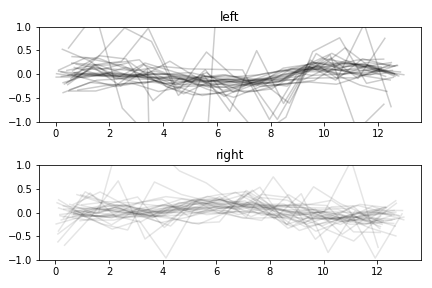

(-1.0, 1.0)

In [155]:
window_size = 13
plot_col = 'proj_lat_vel_ewmfilt'#lat_vel_ewmfilt''

lca_df['t0_w'] = lca_df.t_lc-(window_size/2)
lca_df['t_end_w'] = lca_df.t_lc+(window_size/2)
fragment_dfs_left = []
fragment_dfs_right = []
fig,axs=plt.subplots(2)
for i, lca_df_row in lca_df.iterrows():
    if lca_df_row.direction == 'left':
        
        fragment_df = trip_df[trip_df.t.between(lca_df_row.t0_w, lca_df_row.t_end_w)]
        axs[0].plot(fragment_df.t - lca_df_row.t0_w, fragment_df[plot_col], color='black', alpha=.2)
        axs[0].title.set_text('left')
    elif lca_df_row.direction == 'right':
        fragment_df = trip_df[trip_df.t.between(lca_df_row.t0_w, lca_df_row.t_end_w)]
        axs[1].plot(fragment_df.t - lca_df_row.t0_w, fragment_df[plot_col], color='black', alpha=.1)
        axs[1].title.set_text('right')
        
plt.tight_layout()    
axs[0].set_ylim(-1,1)
axs[1].set_ylim(-1,1)


In [147]:
angular_diff

NameError: name 'angular_diff' is not defined

<IPython.core.display.Javascript object>


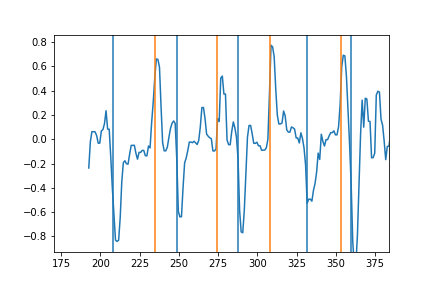

In [143]:
%matplotlib notebook
fig, ax=plt.subplots()
plt.plot(trip_df.t, trip_df.proj_lat_dist_medfilt)
plot_lane_changes(lca_df)

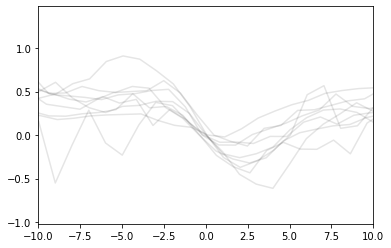

In [140]:
def plot_lane_change_fragments(lca_df, trip_df, column, xlims, ylims=None):
    fig,ax=plt.subplots()
    for t_lc in lca_df.t_lc:
        value_in_middle = trip_df.iloc[abs((trip_df.t - t_lc)).argmin()][column]
        plt.plot(trip_df.t - t_lc, trip_df[column] - value_in_middle, alpha = 0.1, color = 'black')
        plt.xlim(xlims)
        plt.ylim(ylims)


plot_lane_change_fragments(lca_df[lca_df.direction=='left'], trip_df, 'lat_vel_ewmfilt', xlims=(-10,10
                                                                                               ))
    
    

In [29]:
trip_df

,t,date,lat_gps,lon_gps,alt,speed,speed3D,fix,precision,speed_haversine,...,order_road,x,y,lat_vel,offset_ewmfilt,lat_vel_ewmfilt,bearing_diff,proj_lat_dist,bearing_diff_ewmfilt,proj_lat_dist_ewmfilt_sine
0,189.060543,2016-01-01 21:13:53.060000+00:00,51.990354,4.391432,2.863435,25.927,93.276,3.0,131.0,25.968939,...,14,86662.11449,444918.9761,NaN,0.132243,NaN,-0.035873,-0.919532,-0.035873,-0.919532
1,190.055406,2016-01-01 21:13:54.055000+00:00,51.990131,4.391539,2.832435,26.234,94.032,3.0,131.0,26.266393,...,14,86662.11449,444918.9761,-0.316923,-0.056934,-0.190154,-0.025882,-0.670223,-0.029879,-0.773679
2,191.041773,2016-01-01 21:13:55.041000+00:00,51.989906,4.391639,2.736435,26.153,93.996,3.0,131.0,26.334318,...,14,86662.11449,444918.9761,0.147901,-0.047571,0.009493,-0.008086,-0.209928,-0.019556,-0.507686
3,192.032675,2016-01-01 21:13:56.032000+00:00,51.989684,4.391737,2.863435,25.570,92.412,3.0,131.0,25.346293,...,14,86662.11449,444918.9761,0.241804,0.056278,0.104803,-0.004348,-0.111377,-0.013239,-0.339079
4,193.020910,2016-01-01 21:13:57.020000+00:00,51.989466,4.391830,2.644435,25.253,90.648,3.0,131.0,25.379449,...,14,86662.11449,444918.9761,0.476974,0.293336,0.239880,0.005062,0.127168,-0.006214,-0.156101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,2428.046309,2016-01-01 21:15:57.018000+00:00,51.989253,4.392374,3.399879,27.003,96.876,3.0,135.0,25.650221,...,2928,86660.35432,444996.1111,0.393874,9.538270,0.498127,0.014087,0.374006,0.019276,0.511760
2165,2429.025615,2016-01-01 21:15:57.997000+00:00,51.989484,4.392277,3.454879,26.943,96.624,3.0,135.0,28.557916,...,2929,86653.91270,445022.3480,0.016995,9.883438,0.352462,0.001209,0.032153,0.013254,0.352480
2166,2430.064665,2016-01-01 21:15:59.036000+00:00,51.989728,4.392173,3.295879,26.893,97.164,3.0,135.0,26.249821,...,2930,86647.53983,445048.5840,-0.194688,10.046121,0.156568,-0.006946,-0.194913,0.006521,0.182982
2167,2431.065665,2016-01-01 21:16:00.037000+00:00,51.989958,4.392073,3.158879,26.968,96.588,3.0,135.0,26.994261,...,2931,86641.09530,445074.5984,-0.048833,10.138281,0.092069,-0.003410,-0.090498,0.003210,0.085199
